### Reverse Correlation Text Visualization

The goal of this analysis is to create visualization of the continuous story text based on the regional brain activity time course. The script simply loads and group averages the TPJ time course, matches the moment-to-moment activity to the corresponding story words from the annotation file, and then uses a helper function to create a color- based visualization of the corresponding text.  
Further visualizations are then made offline by copying the resulting HTML code into other tools that are better suited for that task, but this script can be used to reproduce the html code generation.

In [1]:
import re, sys
import nilearn
from nilearn import plotting, input_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
from pieman_utils import *
import seaborn as sns
from nilearn.image import new_img_like
from scipy.io.wavfile import write

from IPython.display import Audio
from scipy.io import wavfile

from scipy.stats import zscore
import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/envs/neuroimaging/lib/python3.9/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


### load audio and text

In [2]:
pie_text = pd.read_csv('../data_pieman/01_audio_text/pieman_align_laughter.csv',
                       header = None, 
                       names  = ['text', 'emb_dict', 'onset_time', 'offset_time'],
                       encoding = "utf-8")
tr_shift = 3
tr = 1.5

pie_text['tr'] = divmod(pie_text['onset_time'].values, tr)[0] + tr_shift
print(pie_text.head())

          text emb_dict  onset_time  offset_time    tr
0            I        i   15.089999    15.169999  13.0
1        began    began   15.170000    15.510000  13.0
2           my       my   15.509999    15.699999  13.0
3  illustrious    <unk>   15.710000    16.310000  13.0
4       career   career   16.330000    16.940000  13.0


### load fMRI data

In [3]:
fmri_data = np.load('../data_pieman/03_extract_ts/fmri_data_pieman.npy')
print(fmri_data.shape)

data = fmri_data.copy()
data = np.swapaxes(data, 0,1)
data = np.swapaxes(data, 1,2)
print(data.shape)

(68, 300, 293)
(300, 293, 68)


#### Define and plot brain activity and location

{'coords': [48.86702127659574, -58.01329787234043, 14.295212765957444], 'name': '35.64% Angular_Gyrus; 25.13% Middle_Temporal_Gyrus_temporooccipital_part; 22.21% Lateral_Occipital_Cortex_inferior_division; 16.62% Lateral_Occipital_Cortex_superior_division', 'index_label': 50, 'data_array_index': 49}


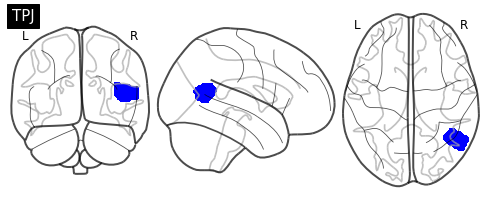

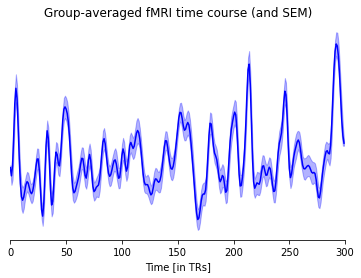

In [4]:
shen_pauli_aan_dict = np.load('../data_pieman/02_rois_masks_maps/shen_pauli_aan_dict.npy', allow_pickle=True).item()

key_regions         = [50]
key_regions_label   = ['TPJ']
colorlist           = ['blue']

for count in range(1):  
    curr_region_dictidx = key_regions[count]
    print(shen_pauli_aan_dict[curr_region_dictidx])
    
    all_file       = '../data_pieman/02_rois_masks_maps/allcombined.nii'
    all_img        = nilearn.image.load_img(all_file)
    all_data       = all_img.get_fdata()

    all_data[np.where(all_data!= curr_region_dictidx)] = 0
    all_new_img    = new_img_like(all_img, all_data.astype(int))

    current_title  = key_regions_label[count]
    display = plotting.plot_glass_brain(None,
                                       title = current_title)
    display.add_contours(all_new_img, filled=True, colors=colorlist[count])
    plt.show()
    

plt.figure(figsize= (6,4));

for count in range(len(key_regions)):
    curr_roi  = shen_pauli_aan_dict[key_regions[count]]['data_array_index']
    curr_data = data[:,curr_roi,:]
    x = np.arange(curr_data.shape[0])
    y = np.mean(curr_data, axis =1) + ((2-count)*2) 
    yerr = np.std(curr_data, axis =1)/np.sqrt(curr_data.shape[1])
    errorfill(x, y, yerr, color=colorlist[count]);

plt.title('Group-averaged fMRI time course (and SEM)');
plt.xlim([0,300])
plt.yticks([]) 
sns.despine(left=True);
blue_patch = mpatches.Patch(color='blue', label='TPJ')
plt.xlabel('Time [in TRs]')
plt.show()

#### align activity with words

0.34612423917108837
['I' 'began' 'my' 'illustrious' 'career']
[0.16363875 0.16363875 0.16363875 0.16363875 0.16363875]


[]

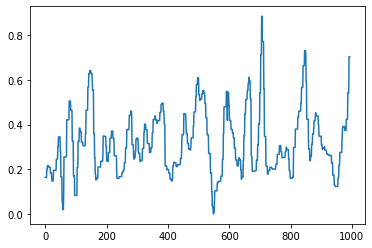

In [5]:
#normalize acts to 0-1
y_norm = (y-min(y))/(max(y)-min(y))

pie_text['reg_act'] = np.nan
for curr_index in range(len(pie_text)):
    #print(curr_index)
    #print(pie_text.loc[curr_index, 'text'])
    curr_tr = pie_text.loc[curr_index, 'tr']
    #print(curr_tr)
    pie_text.loc[curr_index, 'reg_act'] = y_norm[int(curr_tr)]
    #print(y_norm[int(curr_tr)])
    #print('---')

print(np.mean(y_norm))
#plt.plot(y_norm); plt.show()

words = pie_text['text'].values
print(words[:5])

color_array = pie_text['reg_act'].values
print(color_array[:5])

plt.plot(color_array); plt.plot()

#### colorizer function

In [6]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def colorize(words, color_array):
    # words is a list of words
    # color_array is an array of numbers between 0 and 1 of length equal to words
    cmap = matplotlib.cm.get_cmap('RdBu_r')
    template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
    colored_string = ''
    color_array = (0.5-color_array.mean()) + color_array 
    for word, color in zip(words, color_array):
        #print(word)
        color = matplotlib.colors.rgb2hex(cmap(color)[:3])
        colored_string += template.format(color, '&nbsp' + word + '&nbsp')
    return colored_string

# demo
test_words = 'The quick brown fox jumps over the lazy dog'.split()
#color_array = np.random.rand(len(words))
test_color_array = np.array([0 , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
s = colorize(test_words, test_color_array)

# to display in ipython notebook
from IPython.display import display, HTML
display(HTML(s))

#### Colorize text based on brain activity

In [7]:
wr = [s.replace('-' , '') for s in words]
s = colorize(wr, color_array)

# to display in ipython notebook
from IPython.display import display, HTML
display(HTML(s))

#### html code for visualization

In [8]:
s

'<span class="barcode"; style="color: black; background-color: #acd2e5">&nbspI&nbsp</span><span class="barcode"; style="color: black; background-color: #acd2e5">&nbspbegan&nbsp</span><span class="barcode"; style="color: black; background-color: #acd2e5">&nbspmy&nbsp</span><span class="barcode"; style="color: black; background-color: #acd2e5">&nbspillustrious&nbsp</span><span class="barcode"; style="color: black; background-color: #acd2e5">&nbspcareer&nbsp</span><span class="barcode"; style="color: black; background-color: #c2ddec">&nbspin&nbsp</span><span class="barcode"; style="color: black; background-color: #c2ddec">&nbspjournalism&nbsp</span><span class="barcode"; style="color: black; background-color: #cfe4ef">&nbspin&nbsp</span><span class="barcode"; style="color: black; background-color: #cfe4ef">&nbspthe&nbsp</span><span class="barcode"; style="color: black; background-color: #cfe4ef">&nbspBronx&nbsp</span><span class="barcode"; style="color: black; background-color: #cfe4ef">&